# GW Follow up

**Lecturers:** Silvia Piranomonte, Fabio Ragosta<br>
**Jupyter Notebook Authors:** Fabio Ragosta

This Jupyter notebook makes use of materials from Jupyter notebook lesson taken from the GROWTH Summer School 2019 and Jupyter notebook lessons take from ZTF summer school 2022.  For other lessons and their accompanying lectures, please see: http://growth.caltech.edu/growth-school-2019.html ,https://github.com/mcoughlin/ztf_summer_school_2022 

### The data set
Two data files were prepared for this school activity, both in JSON format. JSON files are, essentially, dictionaries.

The alerts were all issued on the night of 2021-02-05 UT. The total number of alerts issued on that night approximated 1 million. If all the alerts were to be used, complete with all their entries, they total disk space for the 2021-02-05 night is larger than 16GB. To facilitate the download and handling of the data, alerts were selected that:
- have at least 2 detections for the source (ndethist >= 2)
- are likely real according to two real/bogus classifiers (drb > 0.8; braai > 0.8)
- left a positive residual after image subtraction, i.e. the flux in the science image is larger than in the template image (warning: the source might have been fainter than the template in a past science image, generating a "negative" subtraction!)

The data files are `data/fast_transient_alerts.json` for the alerts, `data/fast_transient_lc.json` for the light curves.

- `data/fast_transient_alerts.json` Uniform JSON file (readable as a table using `pandas`) containing a selection of relevant information from the original alerts.
- `data/fast_transient_lc.json` Light curves. The light curve of some transients have thousands of data points. To keep the data set manageable and our eyes on the scientific objective to discover fast transients, some the light curves were cut. In particular, **empty light curves** were assigned to those transients that:
    - have at least one "negative" subtraction in the past (see above)
    - are located at Galactic latitude `-8 deg < b < +8 deg` <br>
In addition, only those data points within the last 30 days before the alert was issued are present in the light curves. Long-duration transients, variables, and repeatingly bursting sources are outside the scope of this activity. However, data points acquired after the last alert included in the `fast_transient_alerts.json` file will be present. 

In [28]:
import astropy.utils.data
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import healpy as hp
from astropy.table import Table, vstack, hstack, Column
import astropy.units as u
from astropy.coordinates import SkyCoord
import ligo.skymap.plot
from scipy.stats import norm
import scipy.stats
import json
import matplotlib.pyplot as plt
from collections import OrderedDict

#configure Matplotlib to send plot output directly to the notebook
%matplotlib inline

## HEALPix Basics

This section on using HEALPix localization files is adapted from the [LIGO/Virgo Public Alerts User Guide](https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html).

### Download and read localization

Let's start by downloading a sample localization file from the User Guide. We could do this on the command line using `curl`:

    $ curl -O https://emfollow.docs.ligo.org/userguide/_static/bayestar.fits.gz

But after all, this is a Python lesson, so let's download the file using the handy `astropy.utils.data.download_file` function from Astropy.

In [2]:
url = 'https://emfollow.docs.ligo.org/userguide/_static/bayestar.fits.gz'
filename = astropy.utils.data.download_file(url)

Next, let's read in the HEALPix data using Healpy. Note that by default, Healpy only reads the first column, which provides the 2D probability distribution on the sky.

In [3]:
prob = hp.read_map(filename)

### Manipulating HEALPix Coordinates

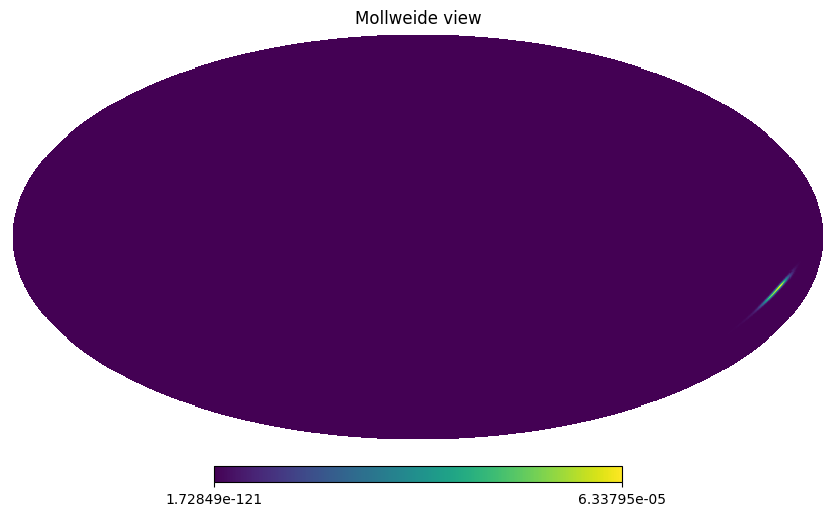

In [4]:
hp.mollview(prob)

It's a one-dimensional array! Yet it represents in 2D image. How does that work? HEALPix is a way to *index* equal-area regions on the unit sphere using integers.

To decode HEALPix indices, you need to know the resolution of the map, which is described by a parameter called `nside`. `nside` is the number of subdivisions of 12 base HEALPix tiles, so the relation between the length of a HEALPix array, `npix`, and its resolution, `nside`, is

$$
    \mathsf{npix} = 12 \cdot \mathsf{nside}^2.
$$




In [5]:
npix = len(prob)
npix

50331648

The functions `hp.npix2nside` and `hp.nside2npix` convert between length and resolution.

In [6]:
nside = hp.npix2nside(npix)
nside

2048


The function `hp.pix2ang` allow us to convert from (ra, dec) and HEALPix pixel index.

*Note*: by default, these functions return 'physics' spherical coordinates $(\theta, \phi)$ in radians, but you can switch to 'astronomy' spherical coordinates in degrees by passing the keyword argument `lonlat=True`.

What is the most probable sky location? Just find the pixel with the maximum value, and then find its right ascension and declination.

In [7]:
ipix_max = np.argmax(prob)
ipix_max

32883013

In [8]:
hp.pix2ang(nside, ipix_max, lonlat=True)

(194.30419921875, -17.856895095545454)

## Probability distributions with scipy.stats

Finding the most probable sky location within a HEALPix map involves knowing which pixels correspond to a certain probability contour (say, 90%).  We can gain insight into how these probability contours are calculated using scipy.stats.  Scipy provides a "t" distribution class that we can use to get values from the "t" statistic probability density function (PDF). As a start, we plot the PDF for a "t" statistic with 3 degrees of freedom:

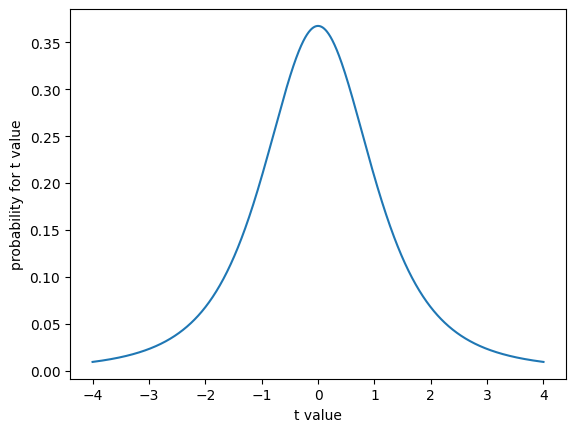

In [9]:
t_dist = scipy.stats.t(3)
t_values = np.linspace(-4, 4, 1000)
plt.plot(t_values, t_dist.pdf(t_values))
plt.xlabel('t value')
plt.ylabel('probability for t value')
plt.show()

The t distribution object t_dist can also give us the cumulative distribution function (CDF). The CDF gives the area under the curve of the PDF at and to the left of the given t value:

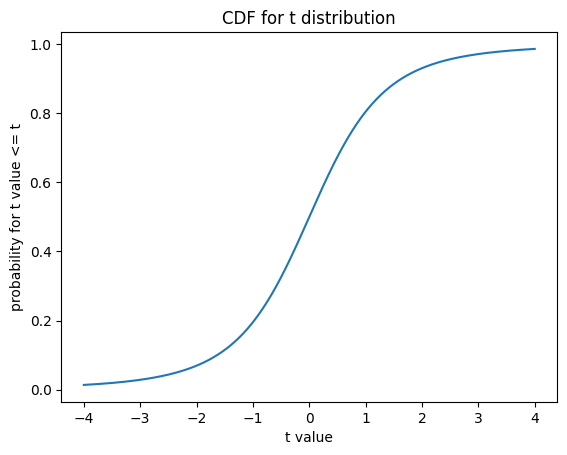

In [10]:
plt.plot(t_values, t_dist.cdf(t_values))
plt.xlabel('t value')
plt.ylabel('probability for t value <= t')
plt.title('CDF for t distribution')
plt.show()

Say I have a t value x drawn from a t distribution. The PDF gives the probability for given values of x. Because it is a probability density, the sum of the probabilities of all possible values for x: ∞<x<∞ must be 1. Therefore the total area under the PDF curve is 1, and the maximum value of the CDF is 1.

The CDF gives us the area under the PDF curve at and to the left of a given t value x. Therefore it is the probability that we will observe a value x<=t if we sample a value x from a t distribution.

Let's show relationship of PDF and CDF for three example t values.

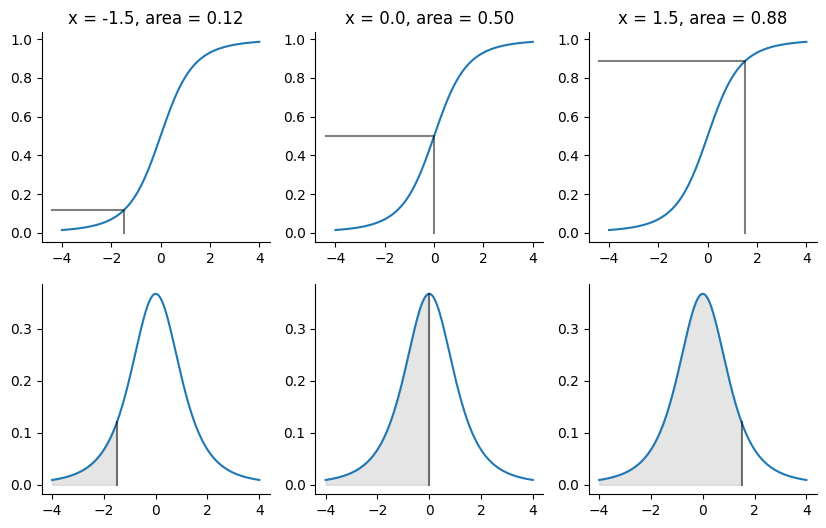

In [11]:
example_values = (-1.5, 0, 1.5)
pdf_values = t_dist.pdf(t_values)
cdf_values = t_dist.cdf(t_values)
fill_color = (0, 0, 0, 0.1)  # Light gray in RGBA format.
line_color = (0, 0, 0, 0.5)  # Medium gray in RGBA format.
fig, axes = plt.subplots(2, len(example_values), figsize=(10, 6))
for i, x in enumerate(example_values):
    cdf_ax, pdf_ax = axes[:, i]
    cdf_ax.plot(t_values, cdf_values)
    pdf_ax.plot(t_values, pdf_values)
    # Fill area at and to the left of x.
    pdf_ax.fill_between(t_values, pdf_values,
                        where=t_values <= x,
                        color=fill_color)
    pd = t_dist.pdf(x)  # Probability density at this value.
    # Line showing position of x on x-axis of PDF plot.
    pdf_ax.plot([x, x],
                [0, pd], color=line_color)
    cd = t_dist.cdf(x)  # Cumulative distribution value for this x.
    # Lines showing x and CDF value on CDF plot.
    x_ax_min = cdf_ax.axis()[0]  # x position of y axis on plot.
    cdf_ax.plot([x, x, x_ax_min],
                [0, cd, cd], color=line_color)
    cdf_ax.set_title('x = {:.1f}, area = {:.2f}'.format(x, cd))
    # Hide top and right axis lines and ticks to reduce clutter.
    for ax in (cdf_ax, pdf_ax):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

## Working with LIGO/Virgo 3D localizations and Cross-Matching to Galaxy Catalogs

To work with Skymaps we need to get a galaxy catalog we can se as reference to search for our candidate.

For this Section we will use a galaxy catalog from the CLU project (Census of the Local Universe; paper: https://ui.adsabs.harvard.edu/abs/2017arXiv171005016C/abstract). However, we will only use those galaxies that are publically availble and in NED (NASA/IPAC Extragalactic Database: https://ned.ipac.caltech.edu/). This catalog has already been prepared for you.

In [12]:
# load CLU catalog into astropy table.
clu=Table.read('CLU.hdf5')
nclu=np.size(clu)

# Add probability columns to the galaxy catalog: probability density and p-value per volume and per area.
probdencol=Column(np.zeros(nclu,dtype='f4'),name='dP_dV')
probcol=Column(np.zeros(nclu,dtype='f4'),name='P')
probdenAcol=Column(np.zeros(nclu,dtype='f4'),name='dP_dA')
probAcol=Column(np.zeros(nclu,dtype='f4'),name='P_A')
clu.add_columns([probdencol,probcol,probdenAcol,probAcol])
clu.colnames

['name',
 'ra',
 'dec',
 'distmpc',
 'a',
 'b2a',
 'pa',
 'btc',
 'magb',
 'sfr_fuv',
 'mstar',
 'dP_dV',
 'P',
 'dP_dA',
 'P_A']

In [13]:
clu['name','ra','dec','distmpc','a','b2a','magb','sfr_fuv','mstar']

name,ra,dec,distmpc,a,b2a,magb,sfr_fuv,mstar
,deg,deg,Mpc,,,,,
bytes30,float64,float64,float64,float64,float64,float64,float64,float64
6dFgs gJ0001313-055904,0.38083,-5.98433,0.0556771419942379,nan,nan,25.301416397094727,nan,336.60756522868667
2MASX J00021772-4345168,0.57383,-43.75467,175.22024536132812,nan,0.416869,16.299999237060547,nan,19468772606.159004
2MASX J00022478-5445592,0.60321,-54.76653,139.5183563232422,nan,0.60256,15.859999656677246,nan,14329555096.85143
MRSS 349-063591,0.74187,-35.79772,198.0797119140625,nan,nan,nan,0.44508742359504405,19799307276.171944
2MASX J00030209-3600152,0.75863,-36.00426,198.10708618164062,nan,nan,nan,nan,25419676830.957485
IRAS F00012-5451 ID,0.948375,-54.5740833333,147.08892822265625,nan,nan,nan,nan,494003437.822152
...,...,...,...,...,...,...,...,...
CLU J121847.9+142422,184.69987120524,14.4063453816313,50.374,nan,nan,nan,nan,nan


'RA'=Right Ascension in degrees <br>
'Dec'=Declination in degrees  <br>
'MODELMAG_R'=SDSS r-band magnitude  <br>
'MODELMAGERR_R'=SDSS r-band magnitude Error  <br>
'K_M_K20FE'=2MASS K-band magnitude  <br>
'K_MSIG_K20FE'=2MASS K-band magnitude Error  <br>
'W1MPRO'=WISE W1 magnitude (3.6 micron)  <br>
'W1SIGMPRO'=WISE W1 magnitude Error  <br>

### Student Exercise
Use the astropy.coordinates package and the SkyCoord function to store all of the galaxy catalog's locations. <br>
The astropy coordinates package provides classes for representing a variety of celestial/spatial coordinates and their velocity components, as well as tools for converting between common coordinate systems in a uniform way. In addition, the astropy coordinates package facilitates fast manipulation and cross-matching. See here for examples: https://docs.astropy.org/en/stable/coordinates/

Create a coordinate object for the entire CLU catalog (hint: use SkyCoord).

In [14]:
# WRITE HERE YOUR CODE

### GW170817 3D Localization

Now let's read in the LIGO/VIRGO HEALpix map for GW170817.

LIGO/Virgo localization files for compact binary mergers include directional estimates of distance. The distance information is stored in three additional columns. To get the distance estimates, we need to ask for all four columns: `PROB`, `DISTMU`, `DISTSIGMA`, and `DISTNORM`.

In [15]:
url = 'https://dcc.ligo.org/public/0146/G1701985/001/preliminary-LALInference.fits.gz'
filename = astropy.utils.data.download_file(url)

prob, distmu, distsigma, distnorm = hp.read_map(filename, field=[0, 1, 2, 3])

npix = len(prob)
nside = hp.npix2nside(npix)
pixarea = hp.nside2pixarea(nside)

`PROB` - cumulative distribution function

`DISTMU` - distance location parameter (Mpc)

`DISTSIGMA` - distance scale parameter (Mpc)

`DISTNORM` - distance normalization factor (Mpc$^{-2}$)

### Student Exercise

Find the coordinates of the highest probability pixel and put the coordinates into an astropy coordinate object called 'center'

In [1]:
# WRITE HERE YOUR CODE

### Other plotting packages for LIGO/VIRGO HEALPix maps.

There are many visualization packages for plotting HEALPix maps. Luckily, LIGO has taken the time to provide its own user-friendly wrapper for plotting LIGO/VIRGO localizations.

Let's plot the sky localization using an 'astroglobe' projection centered on the highest highest probability pixel and overplot this location using the ligo.skymap package. (see here: https://lscsoft.docs.ligo.org/ligo.skymap/plot/allsky.html)

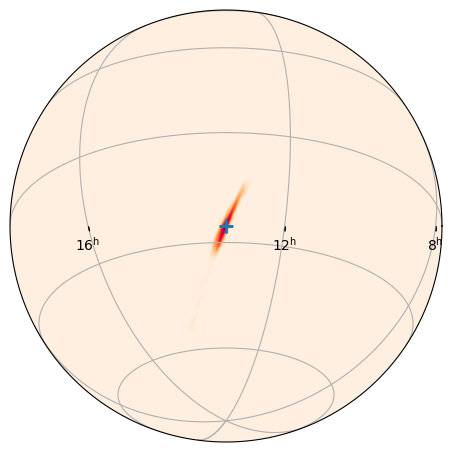

In [17]:
ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax.grid()
ax.imshow_hpx(filename, cmap='cylon')
ax.plot(
    center.ra.deg, center.dec.deg,
    transform=ax.get_transform('world'),
    marker=ligo.skymap.plot.reticle(inner=0,outer=1),
    markersize=10,
    markeredgewidth=2)

### Other plotting packages for LIGO/VIRGO HEALPix maps.

There are many visualization packages for plotting HEALPix maps. Luckily, LIGO has taken the time to provide its own user-friendly wrapper for plotting LIGO/VIRGO localizations.

Let's plot the sky localization using an 'astroglobe' projection centered on the highest highest probability pixel and overplot this location using the ligo.skymap package. (see here: https://lscsoft.docs.ligo.org/ligo.skymap/ligo/skymap/plot/allsky.html)

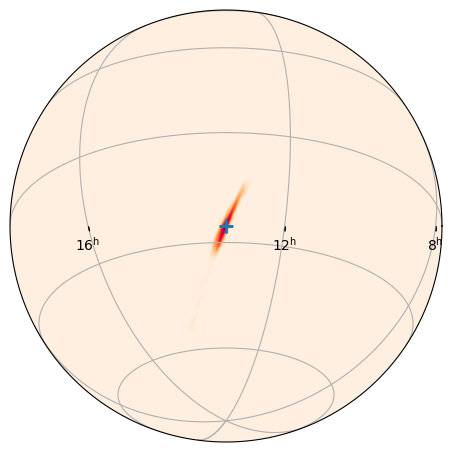

In [18]:
ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax.grid()
ax.imshow_hpx(filename, cmap='cylon')
ax.plot(
    center.ra.deg, center.dec.deg,
    transform=ax.get_transform('world'),
    marker=ligo.skymap.plot.reticle(inner=0,outer=1),
    markersize=10,
    markeredgewidth=2)

### Student Exercises
1. Back to the galaxy catalog. Calculate the HEALPix index for each galaxy.

In [2]:
# WRITE HERE YOUR CODE

2. Compute the probabilities of each galaxy: per area, per radial distance, and per volume.

In [3]:
# WRITE HERE YOUR CODE

3. Use a normalized cumulative dist function to calculate P-value per area for each galaxy (hint: use np.cumsum).

In [4]:
# WRITE HERE YOUR CODE

### Plot the top 20 highest probability galaxies and add a zoomed-in inset.

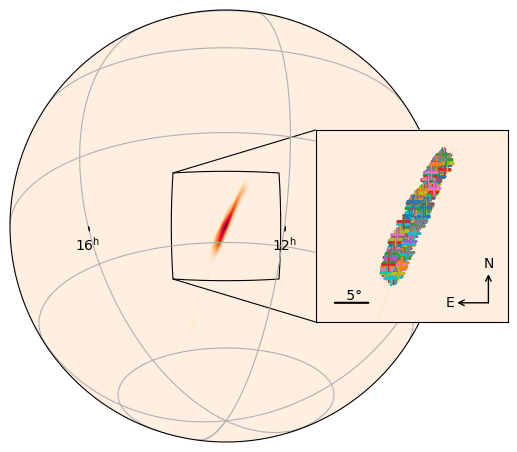

In [22]:
ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

#Zoomed-in inset window to better view the locations of the galaxies.
ax_inset = plt.axes(
    [0.59, 0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=15*u.deg)
for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)
ax.grid()
ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')
ax_inset.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset.compass(0.9, 0.1, 0.2)

ax.imshow_hpx('data/GW170817_prelim.fits.gz', cmap='cylon')
ax_inset.imshow_hpx('data/GW170817_prelim.fits.gz', cmap='cylon')

for coord in clucutarea90coord:
    ax_inset.plot(
    coord.ra.deg, coord.dec.deg,
    transform=ax_inset.get_transform('world'),
    marker=ligo.skymap.plot.reticle(inner=0,outer=1),
    markersize=10,
    markeredgewidth=1)

plt.show()

## Exercise for students - Put it all Together...

Following the examples above, find galaxies in 90% __VOLUME__ probability contour for GW170817, sort by Wise W1 luminosity, and overplot the top 20 sorted galaxies.

Information on WISE zeropoints and flux transformations
http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html

### Part I - Find the galaxies in the 90% volumne probability

In [6]:
# WRITE HERE YOUR CODE


Q: Why are there so fewer galaxies in the volumne probability?
A: Taking into account distance puts tighter constraints on the sample.

Part II - Sort by Stellar Mass

In [5]:
# WRITE HERE YOUR CODE


#Q: Is NGC4993 in your list?
#A: It should be #5

### Part III - Plot up the sky localization and overplot the top 20 sorted galaxies on it.

In [7]:
# WRITE HERE YOUR CODE

# From the Skymap to the candidate search

In [54]:
from ztfquery import query
from astropy.time import Time

In [63]:
zquery = query.ZTFQuery()
jdstart = Time("2019-04-25").jd
jdend = Time("2019-04-26").jd
zquery.load_metadata(sql_query=f"seeing<2 and obsjd BETWEEN {jdstart} AND {jdend}")

In [64]:
query_table = zquery.metatable
query_table

,ra,dec,infobits,field,ccdid,qid,rcid,fid,filtercode,pid,...,ra1,dec1,ra2,dec2,ra3,dec3,ra4,dec4,ipac_pub_date,ipac_gid
0,169.734738,-18.428657,0,318,7,3,26,2,zr,844140352615,...,170.191312,-17.997036,169.282730,-17.992564,169.276154,-18.858933,170.189024,-18.863622,2019-12-11 00:00:00+00,1
1,169.748913,-16.512232,0,318,11,3,42,2,zr,844140354215,...,170.201157,-16.081026,169.301865,-16.075858,169.294896,-16.942185,170.198079,-16.947602,2019-12-11 00:00:00+00,1
2,168.694569,-17.552672,0,318,8,1,28,2,zr,844140352815,...,169.150887,-17.123635,168.246970,-17.114624,168.235789,-17.980979,169.144204,-17.989808,2019-12-11 00:00:00+00,1
3,169.739161,-17.561981,0,318,7,2,25,2,zr,844140352515,...,170.193481,-17.130391,169.289380,-17.126163,169.282712,-17.992554,170.191299,-17.997001,2019-12-11 00:00:00+00,1
4,170.645667,-17.564352,0,318,7,1,24,2,zr,844140352415,...,171.097595,-17.130889,170.193479,-17.130390,170.191319,-17.997043,171.099907,-17.997334,2019-12-11 00:00:00+00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31441,228.819387,4.031493,0,479,5,2,17,1,zg,844506451715,...,229.254920,4.462743,228.388075,4.466254,228.384402,3.599878,229.250555,3.596278,2020-12-09 00:00:00+00,2
31442,229.712473,7.853355,0,479,13,1,48,1,zg,844506454815,...,230.152350,8.282852,229.279436,8.289493,229.273211,7.423104,230.144616,7.416838,2020-12-09 00:00:00+00,2
31443,226.962272,6.998141,0,479,14,3,54,1,zg,844506455415,...,227.400053,7.429481,226.528467,7.432979,226.525584,6.566776,227.395385,6.563079,2020-12-09 00:00:00+00,2
31444,226.953125,3.166668,0,479,6,3,22,1,zg,844506452215,...,227.387041,3.599265,226.520848,3.600366,226.519790,2.734124,227.384994,2.732654,2020-12-09 00:00:00+00,2


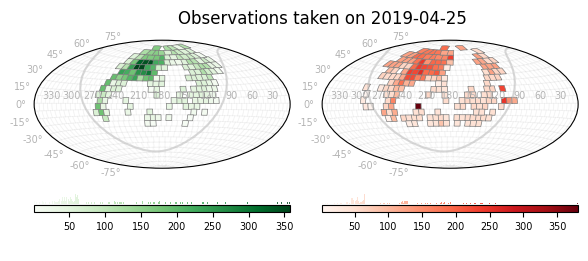

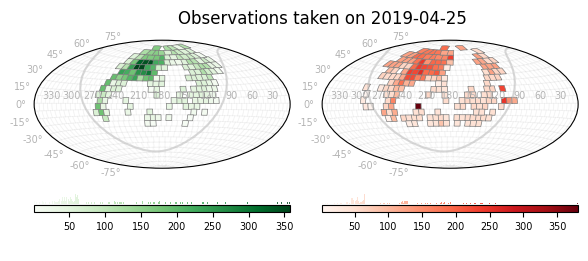

In [65]:
zquery.show_gri_fields(title="Observations taken on 2019-04-25", grid="main")

In [66]:
query_table.columns

Index(['ra', 'dec', 'infobits', 'field', 'ccdid', 'qid', 'rcid', 'fid',
       'filtercode', 'pid', 'nid', 'expid', 'itid', 'imgtype', 'imgtypecode',
       'obsdate', 'obsjd', 'exptime', 'filefracday', 'seeing', 'airmass',
       'moonillf', 'moonesb', 'maglimit', 'crpix1', 'crpix2', 'crval1',
       'crval2', 'cd11', 'cd12', 'cd21', 'cd22', 'ra1', 'dec1', 'ra2', 'dec2',
       'ra3', 'dec3', 'ra4', 'dec4', 'ipac_pub_date', 'ipac_gid'],
      dtype='object')

In [67]:
zquery.load_metadata(sql_query=f"seeing<2 and fid<2 and maglimit>21 and obsjd BETWEEN {jdstart} AND {jdend}")

/opt/miniconda3/envs/etworkshop2024/lib/python3.9/site-packages/ztfquery/fields.py:633: UserWarning: Only one color given, favor using show_fields() directly
  warnings.warn("Only one color given, favor using show_fields() directly")


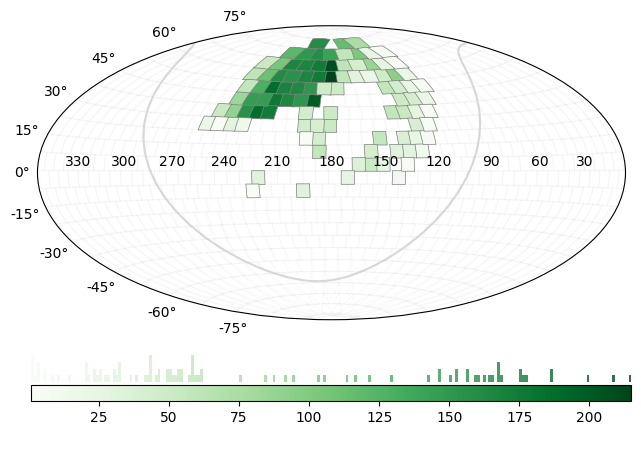

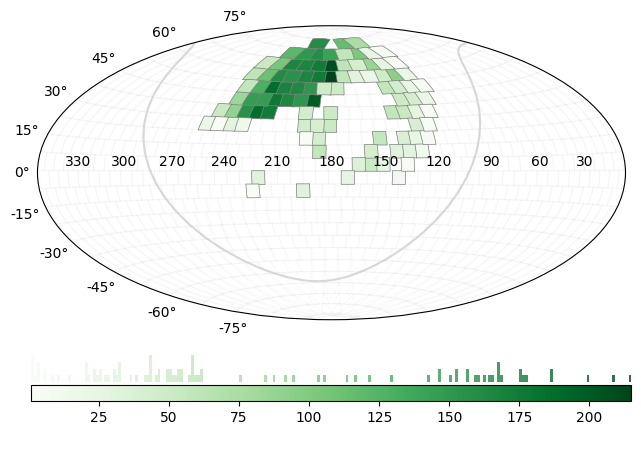

In [68]:
zquery.show_gri_fields(title='deep g-band observations')

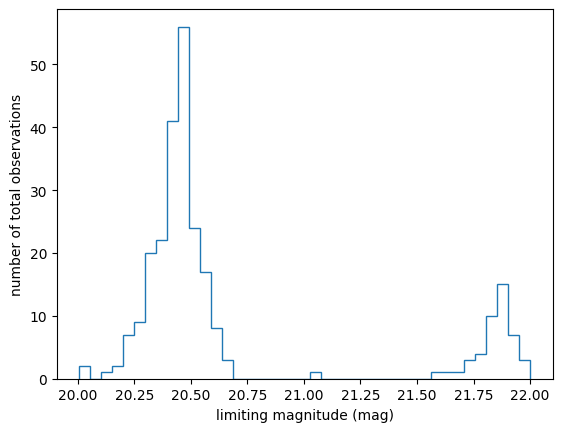

In [70]:
idx = np.argmax(query_table['maglimit'])
query_table['field'][idx], query_table['rcid'][idx]

mask = query_table['field'] == query_table['field'][idx]
plt.figure()
plt.hist(query_table['maglimit'][mask], bins='fd', histtype='step')
plt.ylabel('number of total observations')
plt.xlabel('limiting magnitude (mag)')
plt.show()

In [76]:
from ztfquery import alert
ztfalert = alert.AlertReader.load('./data/2019_01_10_739260766315010006.avro')

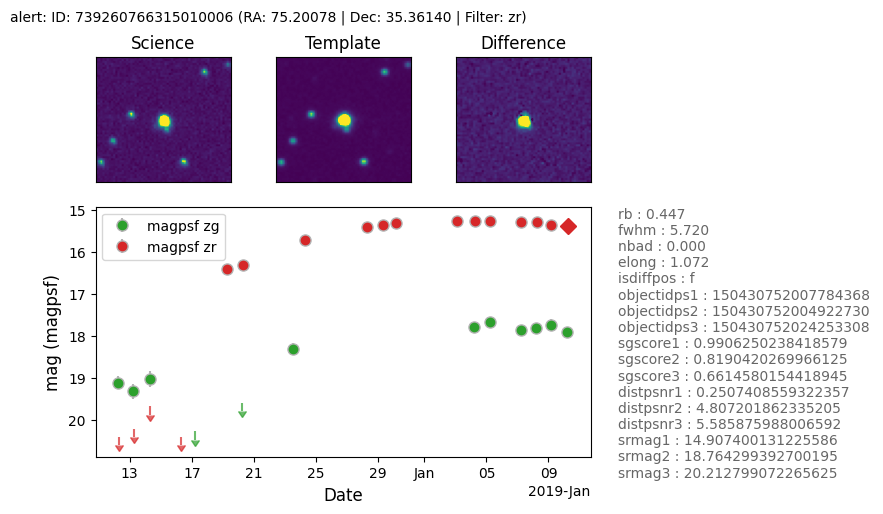

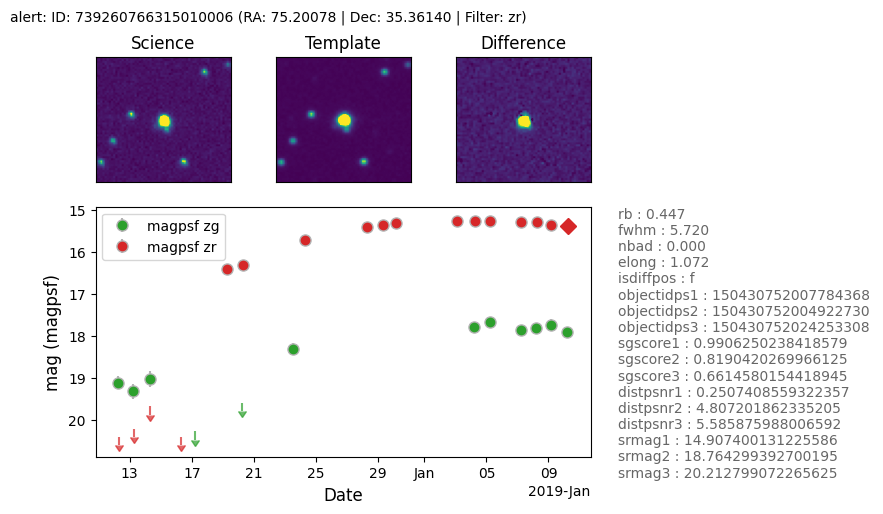

In [83]:
def get_stamp(self, which):
    """ return the HDUImage stamps for `which`.
    where `which` is one of the following ['Science','Template','Difference']
    """
    import gzip, io
    from astropy.io import fits
    with gzip.open(io.BytesIO(self.alert.get("cutout%s"%which)["stampData"]), 'rb') as f:
        return fits.open(io.BytesIO(f.read()),ignore_missing_simple=True)[0]
    
from types import MethodType
ztfalert.get_stamp = MethodType(get_stamp, ztfalert)
ztfalert.show()


Let's take a look at the alert contents. They are stored in ztfalert.alert as a dictionary of dictionaries.

In [78]:
ztfalert.alert

{'schemavsn': '3.2',
 'publisher': 'ZTF (www.ztf.caltech.edu)',
 'objectId': 'ZTF17aaacxxf',
 'candid': 739260766315010006,
 'candidate': {'jd': 2458493.7607639,
  'fid': 2,
  'pid': 739260766315,
  'diffmaglim': 20.550893783569336,
  'pdiffimfilename': 'ztf_20190110260752_000658_zr_c16_o_q4_scimrefdiffimg.fits',
  'programpi': 'Kulkarni',
  'programid': 1,
  'candid': 739260766315010006,
  'isdiffpos': 'f',
  'tblid': 6,
  'nid': 739,
  'rcid': 63,
  'field': 658,
  'xpos': 2469.45654296875,
  'ypos': 2918.46533203125,
  'ra': 75.2007803,
  'dec': 35.3613954,
  'magpsf': 15.371133804321289,
  'sigmapsf': 0.044493019580841064,
  'chipsf': 332.4355773925781,
  'magap': 15.316800117492676,
  'sigmagap': 0.005799999926239252,
  'distnr': 0.2712194621562958,
  'magnr': 14.318999290466309,
  'sigmagnr': 0.01600000075995922,
  'chinr': 0.7440000176429749,
  'sharpnr': 0.04699999839067459,
  'sky': 0.048080768436193466,
  'magdiff': -0.05433399975299835,
  'fwhm': 5.71999979019165,
  'classta

### Take a moment to answer
Which of the quantities provided here (on the side of the cutouts/lightcurve) do you think are most important in determining whether an alert is a real astrophysical transient or not?

### Cross match
Having an alert packet dictionary is quite useful in order to filter on certain criteria that we care about. For example, suppose we wanted to see only the photometry that was obtained as a part of the MSIP survey, we could filter on programid:

In [79]:
alert_dict = ztfalert.alert
MSIP_alerts = []
for alert in alert_dict['prv_candidates']:
    if alert['programid'] == 1:
        MSIP_alerts.append(alert)
print(f"The number of alerts from MSIP data is:{len(MSIP_alerts)}")

The number of alerts from MSIP data is:28


In [81]:
alert_dict = ztfalert.alert
partnership_alerts = []
real_alerts = []
for alert in alert_dict['prv_candidates']:
    if alert['programid'] == 2:
        partnership_alerts.append(alert)
    if alert['rb'] is not None and alert['rb'] > 0.5:
        real_alerts.append(alert)
print("%d percent of the alerts were generated from partnership observations." % (len(partnership_alerts)/len(alert_dict['prv_candidates'])*100))
print("%d percent of the alerts had RB scores greater than 0.5." % (len(real_alerts)/len(alert_dict['prv_candidates'])*100))

0 percent of the alerts were generated from partnership observations.
71 percent of the alerts had RB scores greater than 0.5.


## Read and understand the data

Read the data file. Beware that this action could take several minutes. The alerts JSON file is uniform and can be read as a `pandas` data frame.

In [29]:
# Open the file with the alerts
alerts_filename = "./data/fast_transient_alerts.json"
df_alerts = pd.read_json(alerts_filename)
# To have one alert per row instead of column, use transpose()
df_alerts = df_alerts.transpose()

In [30]:
# Open the file with the light curves
lc_filename = "./data/fast_transient_lc.json"
  
# Opening JSON file
f = open(lc_filename)
  
# returns JSON object as a dictionary
lc_dict = json.load(f)

What do the data look like? It is a good idea to see what the data variables include, but we have to be careful about printing such a large amount of information all at once. Exploring the length of what we are going to print first is racommended.

In [31]:
# How many alerts do we have?
len(df_alerts)

106560

In [32]:
# What is the name of the alerts data frame columns?
df_alerts.columns

Index(['jd', 'fid', 'isdiffpos', 'rcid', 'ra', 'dec', 'magpsf', 'sigmapsf',
       'rb', 'ssdistnr', 'srmag1', 'sgscore1', 'distpsnr1', 'ndethist',
       'jdstarthist', 'jdendhist', 'srmag2', 'sgscore2', 'distpsnr2', 'srmag3',
       'sgscore3', 'distpsnr3', 'drb', 'objectId'],
      dtype='object')

**STOP**. What do these column names mean? In order to use them in a smart way, check them out in the [ZTF Avro schema](https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html)

In [33]:
#What do alerts look like, in this short version?
df_alerts[0:3]

,jd,fid,isdiffpos,rcid,ra,dec,magpsf,sigmapsf,rb,ssdistnr,...,jdstarthist,jdendhist,srmag2,sgscore2,distpsnr2,srmag3,sgscore3,distpsnr3,drb,objectId
601cb75947230767c903ce48,2459250.626065,1,t,45,41.706031,-22.509571,15.914849,0.052548,0.512857,-999.0,...,2458383.932454,2459250.626065,18.7122,1.0,11.778825,-999.0,0.5,15.36731,0.975172,ZTF18abyitqr
601cb758040c9a45b915243b,2459250.626065,1,t,52,46.59873,-20.729952,19.315357,0.187526,0.528571,-999.0,...,2458860.605127,2459250.626065,21.7882,0.906845,5.796002,21.646299,0.923917,13.633864,0.999086,ZTF20aafuwfv
601cb761da8192014092f81a,2459250.626065,1,t,4,46.82753,-27.066677,19.544296,0.215844,0.545714,-999.0,...,2459117.897257,2459250.626065,20.7647,0.005,23.80216,-999.0,-999.0,-999.0,0.988304,ZTF20acekgfz


Let's warm up with selection criteria for the alerts. For example, we can check if any one of the alerts has exactly 20 detections in its history, it is at least 5 arcsec away from the closest PS1 catalog source, and the closest PS1 cataloged source is likely a galaxy. Remember that the star/galaxy classification goes from 0 (likely galaxy) to 1 (likely star).

In [34]:
crit_test = (df_alerts['ndethist'] == 20) & (df_alerts['distpsnr1'] > 5) & (df_alerts['sgscore1'] < 0.5)
df_alerts[crit_test]["objectId"]

601cfaac6fbae9e71c9bcabe    ZTF21aagnvvk
601d038d6fbae9e71c9bd805    ZTF21aagmryd
Name: objectId, dtype: object

Let's display a light curve. For example, the dataset includes ZTF21aagnvvk, which is a Type Ia supernova that was assigned IAU name [AT2021bnf](https://www.wis-tns.org/object/2021bnf). You should have found this transient using the selection criteria in the cell above.

To make things easier, the filter id (`fid`) column was replaced with the `filter` name (g, r, or i) column. Note that upper limits from non-detections are not included in this data set, so you will find only information about detections, even if knowing the last non-detection time of a transient can be crucial to constrain its onset.

In [35]:
lc_dict["ZTF21aagnvvk"]

[{'jd': 2459232.78481, 'magpsf': 20.856, 'sigmapsf': 0.371, 'filter': 'g'},
 {'jd': 2459232.88103, 'magpsf': 20.705, 'sigmapsf': 0.269, 'filter': 'g'},
 {'jd': 2459232.92484, 'magpsf': 20.591, 'sigmapsf': 0.286, 'filter': 'g'},
 {'jd': 2459233.77119, 'magpsf': 20.487, 'sigmapsf': 0.273, 'filter': 'r'},
 {'jd': 2459248.75645, 'magpsf': 19.06, 'sigmapsf': 0.11, 'filter': 'g'},
 {'jd': 2459248.76622, 'magpsf': 19.032, 'sigmapsf': 0.09, 'filter': 'g'},
 {'jd': 2459248.75551, 'magpsf': 19.082, 'sigmapsf': 0.104, 'filter': 'g'},
 {'jd': 2459248.86705, 'magpsf': 18.948, 'sigmapsf': 0.104, 'filter': 'r'},
 {'jd': 2459248.88325, 'magpsf': 18.924, 'sigmapsf': 0.094, 'filter': 'r'},
 {'jd': 2459248.90036, 'magpsf': 19.016, 'sigmapsf': 0.113, 'filter': 'g'},
 {'jd': 2459248.88231, 'magpsf': 19.025, 'sigmapsf': 0.094, 'filter': 'r'},
 {'jd': 2459248.93757, 'magpsf': 19.023, 'sigmapsf': 0.11, 'filter': 'r'},
 {'jd': 2459249.79897, 'magpsf': 19.158, 'sigmapsf': 0.28, 'filter': 'r'},
 {'jd': 2459249.8

## Plot a light curve
Define a function to plot the light curve of a given transient

In [36]:
def plot_lc(name):
    """
    Plot a light curve given a ZTF transient name.
    Assume lc_dict to be a global variable already defined.

    Parameters
    ----------
    name str
        name (objectId) of the ZTF transient
    """
    # Get the lc of interest
    lc = lc_dict[name]
    # What are the filters in which it was observed
    filters = [x["filter"] for x in lc]
    
    # Initialize the figure
    fig, ax = plt.subplots()
    
    # Plot the light curve in each filter
    for f in set(filters):
        time = [x["jd"] for x in lc if x['filter'] == f]
        mag = ...
        magerr = ...
        ax.errorbar(..., ..., yerr=..., marker="o", label=f)
    # Legend without repeatitions
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    # Axes name
    ...
    
    # Note: smaller magnitude means larger luminosity!
    ax.set_ylim(ax.get_ylim()[::-1])

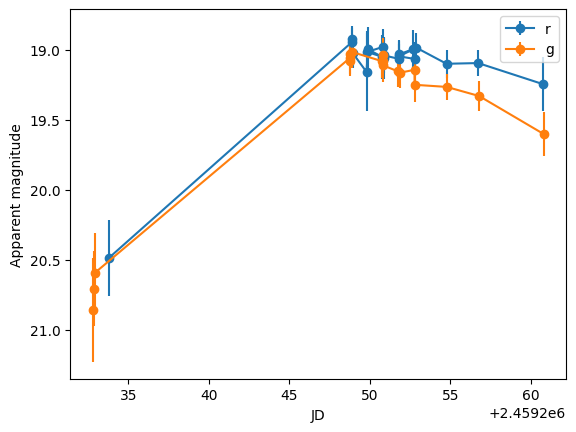

In [37]:
# Try out the new function ZTF21aagnvvk
plot_lc("ZTF21aagnvvk")

Bonus quiz: Now try out the plotting function on ZTF21aagmryd. Can you guess which type of supernova this is ONLY based on the light curve? [solution: a SN Ia is well recognizable from the red bump]

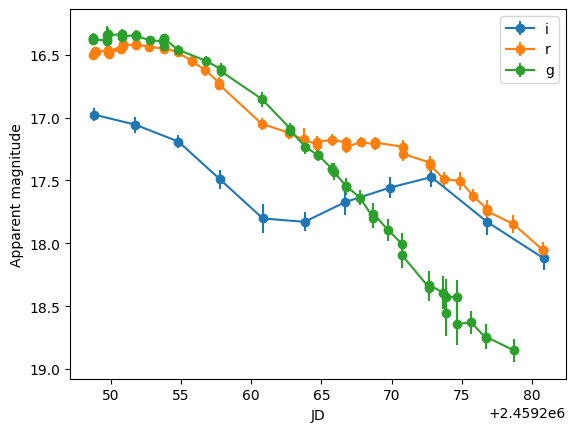

In [38]:
plot_lc("ZTF21aagmryd")

# Fast transient quest

Now the real search for fast transients begins!

## Moving objects

<img src="./figures/figure_asteroid.jpg" width="500"/>

Objects that move in the sky significantly in little time are likely asteroids or other types of natural (or artificial) near-Earth objects. Those must be removed from the sample. 

The ZTF alerts include valuable information such as the distance to the nearest catalogued solar system objects (`ssdistnr`). How many alerts fall within 10 arcsec from a catalog solar system object? Note: if no match is found, `ssdistnr == -999`

In [39]:
crit_moving = (df_alerts["ssdistnr"] < ...) & (df_alerts["ssdistnr"] > 0)
len(df_alerts[crit_moving])

808

In [40]:
# Now define a criterion to EXCLUDE those moving objects
crit_nomoving = ~crit_moving

This is good, but probably not enough to exclude all the moving objects. Some may be uncataloged, and others might not be precisely localized. Another effective way to remove moving objects is to set a minimum time gap between the first and the last detection of a transient. Usually, asteroids move > 1 arcsec every 15 minutes. Our target transients (kilonovae, GRB afterglows) evolve in minutes to days time scales, so we can afford to set a minimum time gap of 30 minutes, for extra safety.

To build this criterion, we can use the `jd` and the `jdstarthist` keys present in every alert. 

In [41]:
crit_mingap = (df_alerts["jd"] - ... > ...)
len(df_alerts[crit_mingap])

89942

Putting the no-moving criteria together, what fraction of alerts remains?

In [42]:
len(df_alerts[crit_nomoving & crit_mingap])/...

0.8430930930930931

## Stellarity
“Dwell on the beauty of life. Watch the stars, and see yourself running with them.” <br>
― Marcus Aurelius, Meditations

“Dwell on the beauty of life. Watch the stars, and see yourself running away from them.” <br>
― Extragalactic Astronomers

<img src="./figures/figure_stellarity.png" alt="drawing" width="400"/>

The star/galaxy classifier can help us remove stellar sources from the sample. As mentioned before, the star/galaxy classification goes from 0 (likely galaxy) to 1 (likely star). We can wonder: 
- is the location of the transient coincident with the location of a catalogued source?
- is the closest source likely a star or a galaxy?

A combination of `sgscore1` and `distpsnr1` will answer both questions. Remember that the PSF of the ZTF camera has FWHM ~ 1 arcsec and the seeing at Palomar Observatory is often 1.0-1.5 arcsec.

In [43]:
crit_stellar = (df_alerts["sgscore1"] > 0.5) & (df_alerts["distpsnr1"] < ...) & (df_alerts["distpsnr1"] >= 0)
crit_nostellar = ~crit_stellar


What fraction of alerts are likely generated by stellar sources? (Imagine what this fraction would be if we included also those sources with Galactic latitude |b| < 8 deg)

In [44]:
len(...)/...

0.7587743993993994

Bonus: plot the light curve of the star with most detections among those never brighter than 17 mag in any band.

In [49]:
...

Ellipsis

## Total duration
We are interested in fast transients, but what this means is somewhat ambiguous. However, if we think of electromagnetic counterparts to gravitational waves, we expect them to remain bright (for a given detection limit) for a few days, perhaps weeks but only for exceptionally nearby or bright cases.

Bonus quiz: assuming that ZTF has a limitng magnitude of ~20.5 mag, how long would a GW170817-like kilonova be detectable in g and r band? What if it was located at 120 Mpc instead of 41 Mpc?

In [45]:
# Set a threshold for the duration
# Set a threshold for the duration
max_duration = ...
crit_maxduration = (... < max_duration)
len(df_alerts[crit_maxduration])

17291

**Note:** The light curves put together for this notebook contain data points that were acquired even **after** the last alert present in the datafile. Therefore some transients pass the total duration criterion, but their light curve plot will show a long-duration transient. Building a criterion based on the light curves rather than on the alerts would yield an even better selection.

# Students Exercise
## Put together the selection criteria
How many alerts are left when the criteria for moving objects, stellarity, and duration are put together? How many transients? What is the fraction of sources that were discarded in the process?

In [8]:
df_alerts_select = df_alerts[crit_nomoving & ... & ... & ...]
print("Number of alerts left:", len(df_alerts_select))
print("Number of transients that pass the cuts:", ...) # remember objectId
# Discarded sources
n_tot_sources = len(set(df_alerts["objectId"]))
n_select_sources = len(set(df_alerts_select["objectId"]))
fraction_discarded = (...)/n_tot_sources
print("Fraction of discarded sources:", fraction_discarded)

This is very good, but is it good enough? Is this sustainable for daily scanning/vetting by humans? It is doable, but we can do better.

## Light curve evolution
We still have a powerful tool that we can use: the rate at which the luminosity changes! The alerts present in the data set were all generated in one night, so we should move to the light curve data at this point.

In Python it is better to stay away from `for` loops, but since we have only a few hundreds of transients left, we can afford to iterate and analyze each light curve individually.

Before doing that, we must define a function that determines whether a light curve shall pass or not pass a given criterion on its evolution. To do things properly, we should consider a rising phase (typically faster) and a fading phase (typically slower) and/or fit models to the data (see, e.g., the methods used in the [ZTFReST](https://ui.adsabs.harvard.edu/abs/2021ApJ...918...63A/abstract) framework). We can build a simplified version of this algorithm.

In [47]:
def evaluate_lc(name, thresh=0.3):
    """
    Evaluate if a light curve evolves fast enough
    Assume lc_dict to be a global variable already defined.

    Parameters
    ----------
    name str
        name (objectId) of the ZTF transient
    thresh float
        threshold for the evolution rate (mag/day)
    
    Returns
    -------
    selected bool
        if the transient fades faster than thresh
        in at least one band, returns True, otherwise False
    """
    # Initialize the variable to return
    selected = False
    # Individual light curve
    lc = lc_dict[name]
    # Iterate on the filters
    filters = ... # See the plot_lc function
    for f in set(filters):
        time = ...
        mag = ...
        magerr = ...
        # Condition for the rise/fade rate
        if np.abs(np.max(mag) - np.min(mag))/(time[np.argmax(mag)]-time[np.argmin(mag)]) > thresh:
            selected = True
            # No need to keep going if selected becomes True
            break
    
    return selected

Let's try it out. How many transients have a light curve that evolves faster than 0.5 mag/day?

In [48]:
names_selected = []
for name in set(df_alerts_select["objectId"]):
    try:
        if evaluate_lc(name, thresh=0.5) is True:
            names_selected.append(name)
    except KeyError:
        print(f"{name} not present in light curve file, ignore")
print("Number of sources to vet:", len(names_selected))

ZTF21aahciex not present in light curve file, ignore
ZTF21aahbxoo not present in light curve file, ignore
ZTF21aahcmda not present in light curve file, ignore
Number of sources to vet: 10


/var/folders/ql/vy585gmd3c977vjcy_cx7dzm0000gn/T/ipykernel_19806/1256737009.py:30: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(np.max(mag) - np.min(mag))/(time[np.argmax(mag)]-time[np.argmin(mag)]) > thresh and time[np.argmax(mag)] - time[np.argmin(mag)] > 0:


In [49]:
names_selected

['ZTF21aagmqux',
 'ZTF21aagolai',
 'ZTF21aahcchj',
 'ZTF21aagkpdw',
 'ZTF21aagnbev',
 'ZTF21aagwbjr',
 'ZTF21aagofbk',
 'ZTF21aagmrpa',
 'ZTF21aagltxy',
 'ZTF21aagoveg']

Plot the light curves and complete the candidate vetting on [Fritz](https://fritz.science). which one of the selected transients is most likely a genuine extragalactic fast transient?

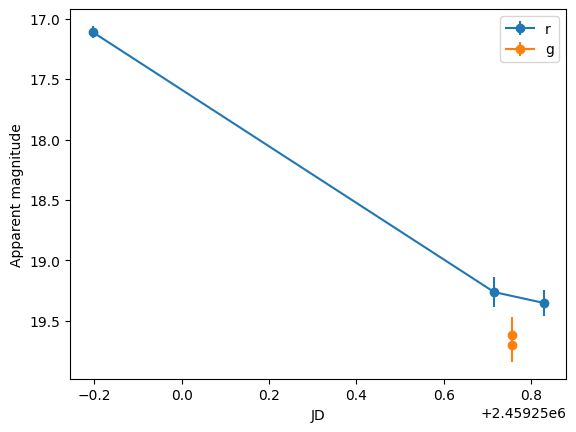

In [50]:
plot_lc('ZTF21aagwbjr')

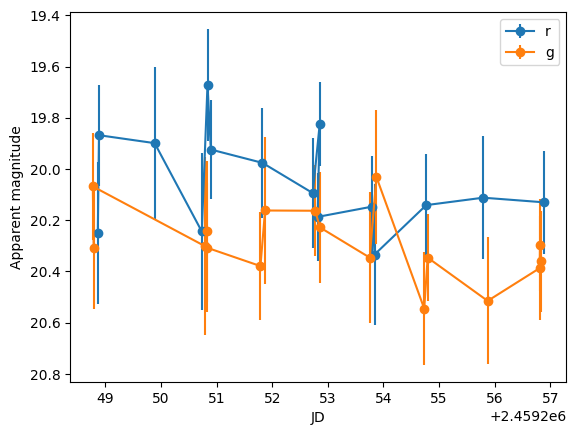

In [51]:
plot_lc('ZTF21aagofbk')

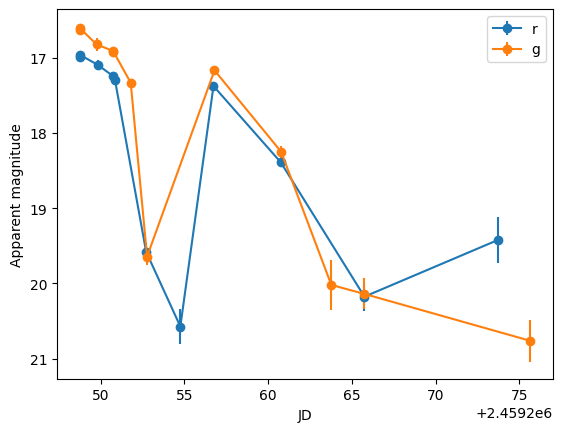

In [52]:
plot_lc('ZTF21aagnbev')

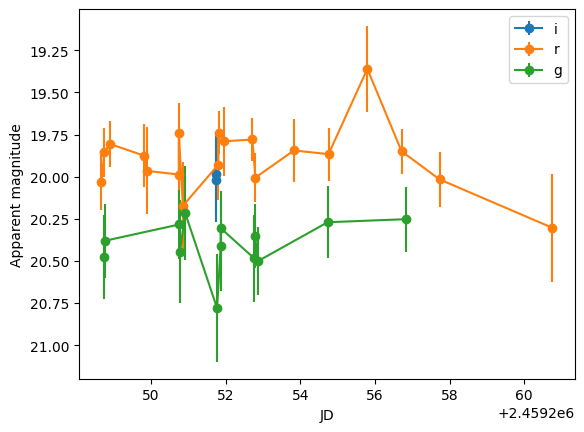

In [53]:
plot_lc('ZTF21aagltxy')

# Epilogue

ZTF21aagwbjr (AT 2021buv, [Kool et al. 2021](https://www.wis-tns.org/astronotes/astronote/2021-54)) was discovered by the ZTF Collaboration as an extragalactic fast transient, independently of any gamma-ray triggers. ZTF21aagwbjr was likely associated with GRB 210204A at redshift z = 0.876 (Xu et al. 2021). ZTF photometry constrained the explosion time within 1.9 hours from the first detection. The transient was serendipitously discovered by the ZTFReST pipeline ([Andreoni & Couglin et al., 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...918...63A/abstract)) and also by the fast-transient filter described in [Ho et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...905...98H/abstract). 

Follow-up observations of ZTF21aagwbjr, prompted by the optical fast transient discovery in real time, revealed the most delayed flares in a Gamma-Ray Burst ([Kumar et al., 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.513.2777K/abstract)).